In [310]:
import os
import zipfile
from pathlib import Path
from shutil import copyfileobj
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print(f"TF version: {tf.__version__}")

TF version: 2.14.0


In [311]:
def archive(dir: Path):
    with zipfile.ZipFile(f"{dir}.zip", "w", zipfile.ZIP_STORED) as zip_file:
        for entry in dir.rglob("*"):
            zip_file.write(entry, entry.relative_to(dir))


def unarchive(file: Path):
    with zipfile.ZipFile(file, "r") as zip_file:
        zip_file.extractall(file.with_suffix(""))

In [312]:
def download_file(url, dataset_file_path):
    path = Path(dataset_file_path)
    os.makedirs(path.parent, exist_ok=True)
    if not path.exists():
        print(f"Downloading {path}")
        with urlopen(url) as fsrc, open(path, "wb") as fdst:
            copyfileobj(fsrc, fdst)
    else:
        print(f"File {path} exists")

In [313]:
dataset_path = "tmp/image_classification/dataset"
batch_size = 32
image_width = 256
image_height = 256
image_size = (image_width, image_height)
image_size_3 = image_size + (3,)
seed = 123
class_count = 20

In [314]:
download_file("https://huggingface.co/datasets/Matthijs/snacks/resolve/main/images.zip", f"{dataset_path}.zip")

File tmp\image_classification\dataset.zip exists


In [315]:
unarchive(Path(f"tmp/image_classification/dataset.zip"))

In [316]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f"{dataset_path}/data/train",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=seed,
    interpolation="bicubic",
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f"{dataset_path}/data/val",
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False,
    seed=seed,
    interpolation="bicubic",
)
assert train_dataset.class_names == validation_dataset.class_names
assert len(train_dataset.class_names) == class_count
# train_dataset=train_dataset.cache().prefetch(10000).shuffle(10000)
# validation_dataset=validation_dataset.cache().prefetch(10000)

Found 4838 files belonging to 20 classes.
Found 955 files belonging to 20 classes.


In [317]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
    tf.keras.layers.Input(image_size_3),

    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.15),
    tf.keras.layers.RandomBrightness(0.1, value_range=[0.0, 255.0]),
    tf.keras.layers.Layer(name="augmentation_end"),

    tf.keras.layers.Rescaling(1 / 255.0),

    # Pixel noise
    # layers.Dropout(0.05, noise_shape=image_size + (1,), name=f"dropout_xy_1"),
    # # Horizontal line noise
    # layers.Dropout(0.1, noise_shape=(image_height, 1, 1), name=f"dropout_x_1"),
    # # Vertical line noise
    # layers.Dropout(0.1, noise_shape=(1, image_width, 1), name=f"dropout_y_1"),

    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    # layers.Dropout(0.05),
    # layers.LayerNormalization(),
    # layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    # layers.Dropout(0.05),
    # layers.LayerNormalization(),
    # layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    # layers.Dropout(0.05),
    # layers.LayerNormalization(),
    # layers.BatchNormalization(),
    layers.Flatten(),
    # layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dense(class_count, activation="softmax", name=f"output")
])

In [318]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_21 (RandomFlip  (None, 256, 256, 3)       0         
 )                                                               
                                                                 
 random_rotation_21 (Random  (None, 256, 256, 3)       0         
 Rotation)                                                       
                                                                 
 random_zoom_21 (RandomZoom  (None, 256, 256, 3)       0         
 )                                                               
                                                                 
 random_translation_21 (Ran  (None, 256, 256, 3)       0         
 domTranslation)                                                 
                                                                 
 random_contrast_21 (Random  (None, 256, 256, 3)      

In [319]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["acc"]
)

In [320]:
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=f"tmp/checkpoints",
#     save_weights_only=False,
#     monitor=f"val_acc",
#     mode="max",
#     save_best_only=True,
# )
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=f"val_acc",
    mode="max",
)

In [322]:
epochs = 1
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[reduce_lr_callback],
)

152/152 [==============================] - 204s 1s/step - loss: 2.4443 - acc: 0.2470 - val_loss: 2.5831 - val_acc: 0.2366 - lr: 0.0010


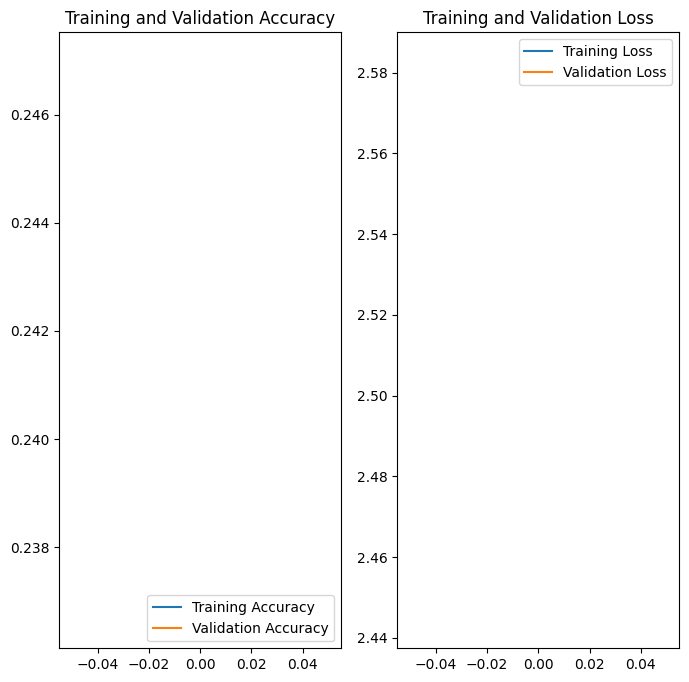

In [327]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [309]:
model.save("tmp/model.h5", save_format="h5")